In [50]:
import yfinance as yf
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import matplotlib.pyplot as plt

### 1. Find which pairs are cointegrated using 2 year data 2020-01-01 until 2022-12-31

Note : Cointegration no need test stationarity. If stationary series then theres no trend to speak of (i hope i understand this right)

In [51]:
start_date = "2015-01-01"
end_date = "2022-12-31"

In [52]:
# get close data
jpy_usd = yf.Ticker("JPYUSD=X").history(start=start_date, end=end_date)["Close"]
cad_usd = yf.Ticker("CADUSD=X").history(start=start_date, end=end_date)["Close"]
eur_usd = yf.Ticker("EURUSD=X").history(start=start_date, end=end_date)["Close"]
gbp_usd = yf.Ticker("GBPUSD=X").history(start=start_date, end=end_date)["Close"]
chf_usd = yf.Ticker("CHFUSD=X").history(start=start_date, end=end_date)["Close"]

# merge to one data frame
df_data = pd.DataFrame(
    zip(jpy_usd, cad_usd, eur_usd, gbp_usd, chf_usd),
    columns=["JPYUSD", "CADUSD", "EURUSD", "GBPUSD", "CHFUSD"],
)
ccy_list = list(df_data.columns)

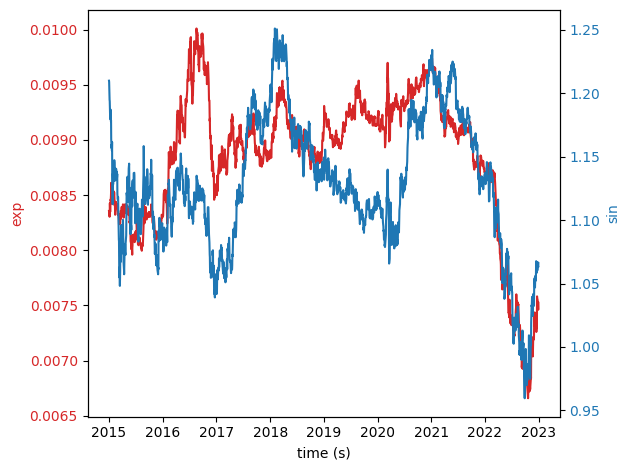

In [53]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("time (s)")
ax1.set_ylabel("exp", color=color)
ax1.plot(jpy_usd, color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel("sin", color=color)  # we already handled the x-label with ax1
ax2.plot(eur_usd, color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

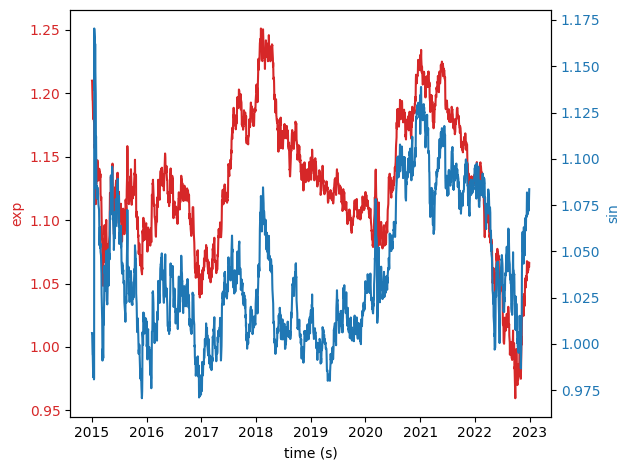

In [54]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("time (s)")
ax1.set_ylabel("exp", color=color)
ax1.plot(eur_usd, color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel("sin", color=color)  # we already handled the x-label with ax1
ax2.plot(chf_usd, color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [55]:
confidence_dict = {90: 0, 95: 1, 99: 2}

In [56]:
# combination
basket_size = range(2, len(ccy_list) + 1)
results_list = []

for the_size in basket_size:
    perm = combinations(ccy_list, the_size)
    for i in perm:
        df_check_coint = df_data[list(i)]
        coint_test_result = coint_johansen(df_check_coint, det_order=0, k_ar_diff=1)

        trace_statistic = coint_test_result.lr1
        maxeigen_statistic = coint_test_result.lr2
        trace_crit_val = coint_test_result.cvt
        maxeigen_crit_val = coint_test_result.cvm

        eigenvectors = coint_test_result.evec

        for x in confidence_dict.keys():
            confidence_level_col = confidence_dict[x]
            trace_crit_val_test = trace_crit_val[:, confidence_level_col]
            maxeigen_crit_val_test = maxeigen_crit_val[:, confidence_level_col]
            if np.all(trace_statistic >= trace_crit_val_test) and np.all(
                maxeigen_statistic >= maxeigen_crit_val_test
            ):
                print(f"For convidence level {x}%, bucket {i} is cointegrated")
                print(f"eigen vectors {eigenvectors[:,0]}")
                print(f"hedge weights {eigenvectors[:,0]/abs(eigenvectors[:,0][0])}")
                results_list.append(
                    {
                        "bucketname": i,
                        "eigenvectors": eigenvectors[:, 0],
                        "weights": eigenvectors[:, 0] / abs(eigenvectors[:, 0][0]),
                    }
                )

For convidence level 90%, bucket ('CADUSD', 'EURUSD') is cointegrated
eigen vectors [42.34339454 -6.33768459]
hedge weights [ 1.         -0.14967351]
For convidence level 95%, bucket ('CADUSD', 'EURUSD') is cointegrated
eigen vectors [42.34339454 -6.33768459]
hedge weights [ 1.         -0.14967351]
For convidence level 99%, bucket ('CADUSD', 'EURUSD') is cointegrated
eigen vectors [42.34339454 -6.33768459]
hedge weights [ 1.         -0.14967351]
For convidence level 90%, bucket ('CADUSD', 'GBPUSD') is cointegrated
eigen vectors [ 3.78928071e+01 -3.14411344e-02]
hedge weights [ 1.00000000e+00 -8.29738855e-04]
For convidence level 95%, bucket ('CADUSD', 'GBPUSD') is cointegrated
eigen vectors [ 3.78928071e+01 -3.14411344e-02]
hedge weights [ 1.00000000e+00 -8.29738855e-04]
For convidence level 90%, bucket ('CADUSD', 'CHFUSD') is cointegrated
eigen vectors [ 38.09388399 -26.95459477]
hedge weights [ 1.         -0.70758326]
For convidence level 95%, bucket ('CADUSD', 'CHFUSD') is cointegra

### 2. Test Spread

In [57]:
results_list

[{'bucketname': ('CADUSD', 'EURUSD'),
  'eigenvectors': array([42.34339454, -6.33768459]),
  'weights': array([ 1.        , -0.14967351])},
 {'bucketname': ('CADUSD', 'EURUSD'),
  'eigenvectors': array([42.34339454, -6.33768459]),
  'weights': array([ 1.        , -0.14967351])},
 {'bucketname': ('CADUSD', 'EURUSD'),
  'eigenvectors': array([42.34339454, -6.33768459]),
  'weights': array([ 1.        , -0.14967351])},
 {'bucketname': ('CADUSD', 'GBPUSD'),
  'eigenvectors': array([ 3.78928071e+01, -3.14411344e-02]),
  'weights': array([ 1.00000000e+00, -8.29738855e-04])},
 {'bucketname': ('CADUSD', 'GBPUSD'),
  'eigenvectors': array([ 3.78928071e+01, -3.14411344e-02]),
  'weights': array([ 1.00000000e+00, -8.29738855e-04])},
 {'bucketname': ('CADUSD', 'CHFUSD'),
  'eigenvectors': array([ 38.09388399, -26.95459477]),
  'weights': array([ 1.        , -0.70758326])},
 {'bucketname': ('CADUSD', 'CHFUSD'),
  'eigenvectors': array([ 38.09388399, -26.95459477]),
  'weights': array([ 1.        , 

In [58]:
# trial 1
spread = (
    cad_usd * results_list[0]["weights"][0] - eur_usd * results_list[0]["weights"][1]
)
adftest = adfuller(spread)

In [59]:
print(f"adf statistic : {adftest[0]}, p value : {adftest[1]}")

adf statistic : -3.8321087920869537, p value : 0.002595365343802799


### 3. Apply some mean reversion signal generation to the spread

In [60]:
# long run mean, std dev etc
lr_mean = spread.mean()
std_dev = spread.std()
print(f"mean = {lr_mean} ; std_dev = {std_dev}")

mean = 0.9375430285487706 ; std_dev = 0.03126528210525145


In [61]:
# rsi because why not, follow some dude online
def rsi(series, window_period):
    change = series.diff()
    change.dropna(inplace=True)
    change_up = change.copy()
    change_down = change.copy()
    change_up[change_up < 0] = 0
    change_down[change_down > 0] = 0
    # Calculate the rolling average of average up and average down
    avg_up = change_up.rolling(window_period).mean()
    avg_down = change_down.rolling(window_period).mean().abs()
    rsi = 100 * avg_up / (avg_up + avg_down)
    return rsi

In [62]:
# something resembling a z score
def z_score(series, lr_mean, std_dev):
    return (series - lr_mean) / std_dev

Date
2015-01-01 00:00:00+00:00    3.343219
2015-01-02 00:00:00+00:00    3.340231
2015-01-05 00:00:00+00:00    2.853777
2015-01-06 00:00:00+00:00    2.933271
2015-01-07 00:00:00+00:00    2.718936
                               ...   
2022-12-26 00:00:00+00:00   -1.344074
2022-12-27 00:00:00+00:00   -1.300509
2022-12-28 00:00:00+00:00   -1.246152
2022-12-29 00:00:00+00:00   -1.379318
2022-12-30 00:00:00+00:00   -1.281977
Name: Close, Length: 2084, dtype: float64

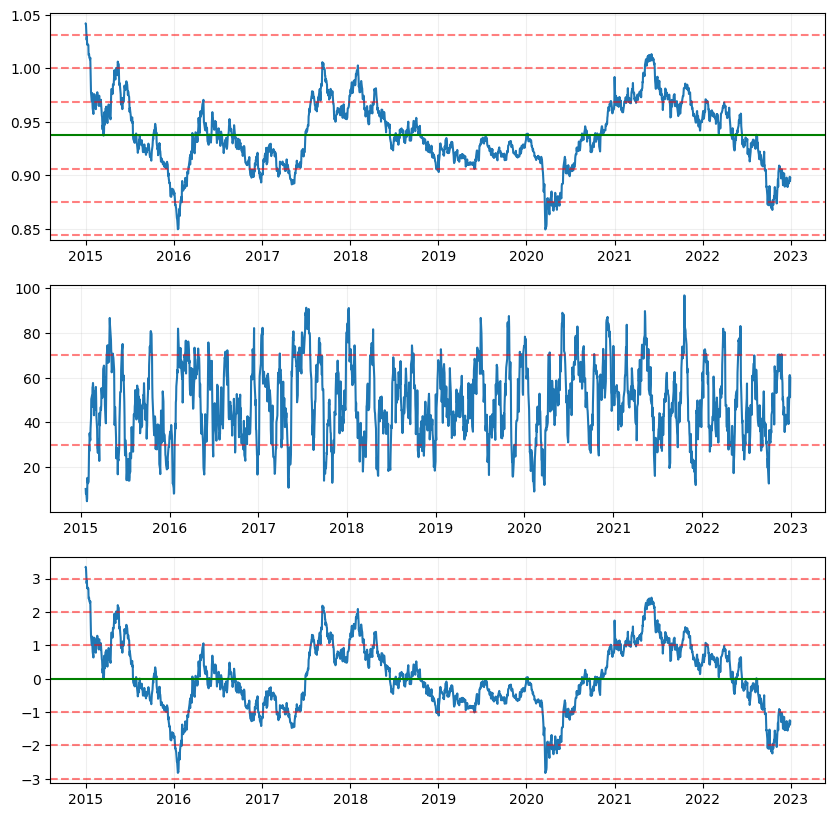

In [67]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.grid(alpha=0.2)
plt.plot(spread)
plt.axhline(lr_mean + std_dev, color="red", linestyle="dashed", alpha=0.5)
plt.axhline(lr_mean + 2 * std_dev, color="red", linestyle="dashed", alpha=0.5)
plt.axhline(lr_mean + 3 * std_dev, color="red", linestyle="dashed", alpha=0.5)
plt.axhline(lr_mean - 1 * std_dev, color="red", linestyle="dashed", alpha=0.5)
plt.axhline(lr_mean - 2 * std_dev, color="red", linestyle="dashed", alpha=0.5)
plt.axhline(lr_mean - 3 * std_dev, color="red", linestyle="dashed", alpha=0.5)
plt.axhline(lr_mean, color="green")
plt.subplot(3, 1, 2)
plt.grid(alpha=0.2)
plt.plot(rsi(spread, 14))
plt.axhline(70, color="red", linestyle="dashed", alpha=0.5)
plt.axhline(30, color="red", linestyle="dashed", alpha=0.5)
plt.subplot(3, 1, 3)
plt.grid(alpha=0.2)
plt.plot(z_score(spread, lr_mean, std_dev))
plt.axhline(1, color="red", linestyle="dashed", alpha=0.5)
plt.axhline(2, color="red", linestyle="dashed", alpha=0.5)
plt.axhline(3, color="red", linestyle="dashed", alpha=0.5)
plt.axhline(-1, color="red", linestyle="dashed", alpha=0.5)
plt.axhline(-2, color="red", linestyle="dashed", alpha=0.5)
plt.axhline(-3, color="red", linestyle="dashed", alpha=0.5)
plt.axhline(0, color="green")

### Strategy :
* Buy on next close if : RSI < 30 and Z < -1
* Sell on next close if : RSI > 70 and Z < 1

Date
2015-01-01 00:00:00+00:00    3.343219
2015-01-02 00:00:00+00:00    3.340231
2015-01-05 00:00:00+00:00    2.853777
2015-01-06 00:00:00+00:00    2.933271
2015-01-07 00:00:00+00:00    2.718936
                               ...   
2022-12-26 00:00:00+00:00   -1.344074
2022-12-27 00:00:00+00:00   -1.300509
2022-12-28 00:00:00+00:00   -1.246152
2022-12-29 00:00:00+00:00   -1.379318
2022-12-30 00:00:00+00:00   -1.281977
Name: Close, Length: 2084, dtype: float64

In [91]:
rsi_14 = rsi(spread, 14)
the_z = z_score(spread, lr_mean, std_dev)
the_z = the_z.to_frame()
the_z.columns = ["zval"]
rsi_14 = rsi_14.to_frame()
rsi_14.columns = ["rsi_14"]

In [96]:
df_merged = the_z.merge(rsi_14, how="left", left_on=the_z.index, right_on=rsi_14.index)

In [ ]:
def strategy(data):
    for row in df_merged.iterrows():
        print(row)